In [4]:
import numpy as np  
import matplotlib.pyplot as plt 
import scipy.signal as sp
import numpy.linalg as nplin
from gekko import GEKKO

from scipy.integrate import odeint
from scipy.signal import place_poles

from plotfunc import plot_sets

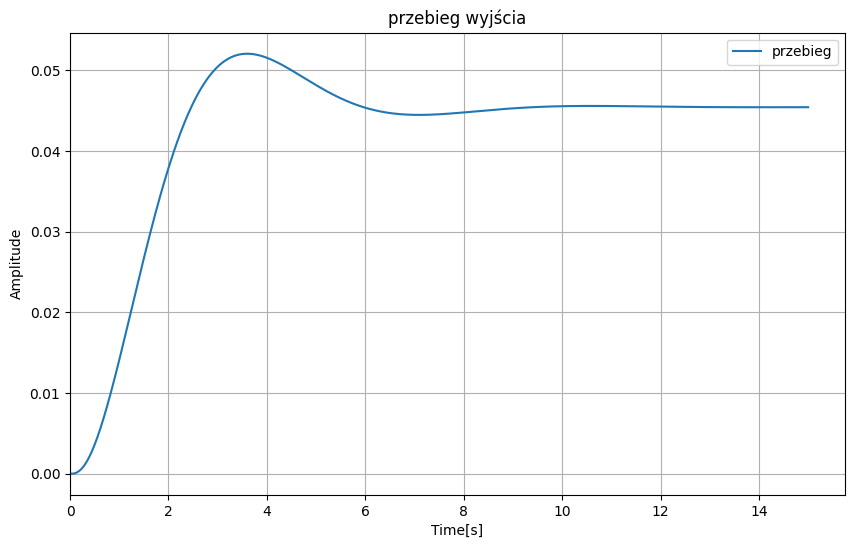

In [27]:
def model(x,t):
    R1=2
    R2=5
    C1=0.5
    L1=2
    L2=0.5

    u=np.array([[1]])

    A=np.array([[-R1/L1,0,-1/L1],[0,-R2/L2,1/L1],[1/C1,-1/C1,0]])
    B=np.array([[1/L1],[0],[0]])
    C=np.array([[0,1,0]])
    D=0

    dx=A@x+(B*u).flatten()
    return dx

x0 = np.array([0, 0, 0])  # [i1, i2, uc]

t = np.linspace(0, 15, 1000)

x = odeint(model, x0, t)

y = x[:, 1]
plot_sets('przebieg wyjścia',[t,y,'przebieg'])


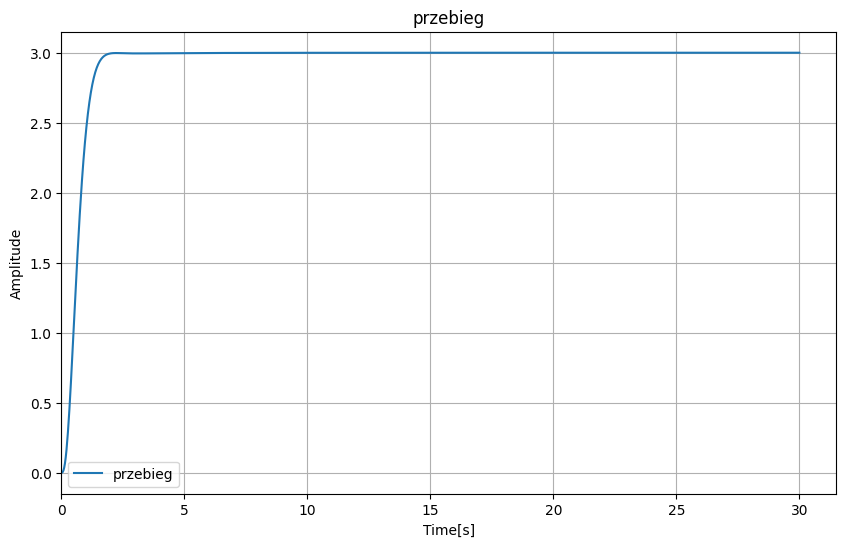

In [ ]:
def model_with_pid(x, t, kp, ki, kd, yd):
    R1, R2 = 2, 5
    L1, L2 = 2, 0.5
    C1 = 0.5
    
    # Rozdzielenie stanu
    i1, i2, uc = x[0], x[1], x[2]
    integral_e = x[3]  # całka z błędu
    
    # Macierze układu
    A = np.array([[-R1/L1, 0, -1/L1],
                  [0, -R2/L2, 1/L2],
                  [1/C1, -1/C1, 0]])
    B = np.array([1/L1, 0, 0])
    C = np.array([0, 1, 0])  # y = i2
    
    y = C @ np.array([i1, i2, uc])
    
    e = yd - y

    dy_dt = C @ (A @ np.array([i1, i2, uc]))
    de_dt = -dy_dt
    
    u = kp * e + ki * integral_e + kd * de_dt
    
    dx_plant = A @ np.array([i1, i2, uc]) + B * u
    
    d_integral_e = e
    
    return [dx_plant[0], dx_plant[1], dx_plant[2], d_integral_e]

# Parametry regulatora PID
kp = 30
ki = 10
kd = 15
yd = 3  # wartość zadana

x0 = np.array([0, 0, 0, 0])

t = np.linspace(0, 30, 1000)

x1 = odeint(model_with_pid, x0, t, args=(kp, ki, kd, yd))

y = x1[:, 1]

plot_sets('przebieg',[t,y,'przebieg'])

# zigler nichols


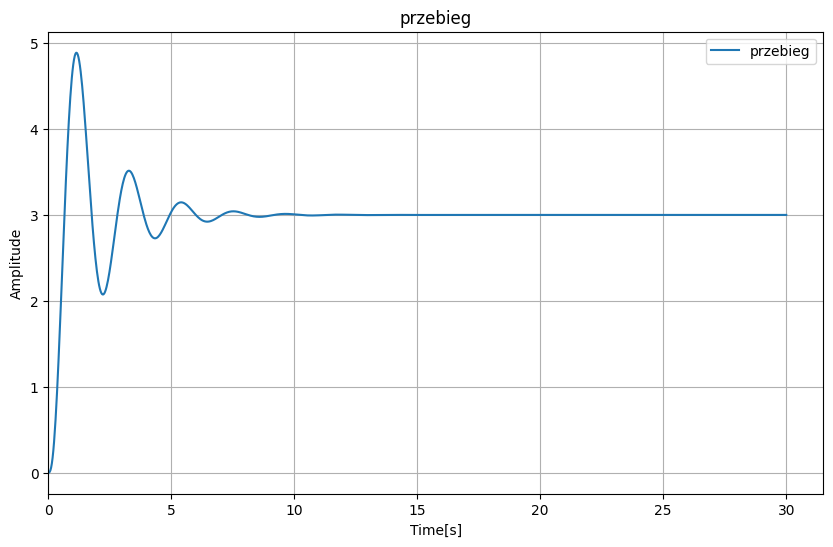

In [68]:
def model_with_pid(x, t, kp, ki, kd, yd):
    R1, R2 = 2, 5
    L1, L2 = 2, 0.5
    C1 = 0.5
    
    # Rozdzielenie stanu
    i1, i2, uc = x[0], x[1], x[2]
    integral_e = x[3]  # całka z błędu
    
    # Macierze układu
    A = np.array([[-R1/L1, 0, -1/L1],
                  [0, -R2/L2, 1/L2],
                  [1/C1, -1/C1, 0]])
    B = np.array([1/L1, 0, 0])
    C = np.array([0, 1, 0])  # y = i2
    
    y = C @ np.array([i1, i2, uc])
    
    e = yd - y

    dy_dt = C @ (A @ np.array([i1, i2, uc]))
    de_dt = -dy_dt
    
    u = kp * e + ki * integral_e + kd * de_dt
    
    dx_plant = A @ np.array([i1, i2, uc]) + B * u
    
    d_integral_e = e
    
    return [dx_plant[0], dx_plant[1], dx_plant[2], d_integral_e]

# Parametry regulatora PID
kp = 45     # ku =75 kp=0.6ku=45
ki = 56.25      # Tu approx 1,6 ki=1.2kuTu^-1=
kd = 9        # kd =0.075kuTu=9
yd = 3  # wartość zadana

x0 = np.array([0, 0, 0, 0])

t = np.linspace(0, 30, 1000)

x1 = odeint(model_with_pid, x0, t, args=(kp, ki, kd, yd))

y = x1[:, 1]

plot_sets('przebieg',[t,y,'przebieg'])